# IMPORT REQUIRED LIBRARY

At this stage import the important library. for model development needs.

In [1]:
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
import dill

# SETUP CONSTANTS

In this block, we define various constants used in the model training and evaluation process. These constants include the paths (directories) for the dataset, model objects, training reports, and important hyperparameters such as batch size, number of epochs, image size, and optimization parameters.

## function

In [2]:
def load_object(file_path):
    """
    A function to load objects from a file using the `dill` module.

    Args:
    file_path (str): File location of the object to be loaded.

    Returns:
    object: Object loaded from file.
    """

    try:
        with open(file_path, 'rb') as file_obj:
            return dill.load(file_obj)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

## main program

In [9]:
# ==========================================================================================
# ==================================== PARENT PATH CONSTANT ================================
# ==========================================================================================
PARENT_DATASET_PATH = ".."
ARTIFACTS_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts")
DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_transformation")
OBJECT_PATH = os.path.join(ARTIFACTS_PATH, "objects")
REPORT_PATH = os.path.join(ARTIFACTS_PATH, "reports")
MODEL_PATH = os.path.join(ARTIFACTS_PATH, "models")


# ==========================================================================================
# ==================================== DATA PATH CONSTANT ==================================
# ==========================================================================================
TRAIN_TFRECOARD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "train_trashnet.tfrecord")
VALID_TFRECORD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "valid_trashnet.tfrecord")


# ==========================================================================================
# =============================== OBJECT PATH CONSTANT  ====================================
# ==========================================================================================
MODEL_NAME = "DenseNet121"
TARGET_KERAS_MODEL_PATH = os.path.join(MODEL_PATH, f"{MODEL_NAME}_model.keras")
LABEL_LIST_PATH = os.path.join(OBJECT_PATH, "label_list.pkl")
CLASS_WEIGHTS_PATH = os.path.join(OBJECT_PATH, "class_weights.pkl")


# ==========================================================================================
# =============================== HYPERPARAMETER CONSTANT  =================================
# ==========================================================================================
IMAGE_SIZE = (224, 224)

# PREDICTION

## function

In [10]:
def show_multiple_images_with_label_pred_tf_data(
    model,
    dataset,
    n_skip,
    num_images,
    figsize_per_image=(2, 2),
    classes_list=None
):
    """
    Displays multiple images with labels and model predictions.
    This code supports multiclass prediction and can work with batch data.

    Args:
    model: The machine learning model used for prediction.
    dataset: The TensorFlow dataset with images and labels.
    n_skip: The number of images to skip in the dataset before displaying.
    num_images: The number of images to display.
    figsize_per_image: The size of each image in the grid (default = (2, 2)).
    classes_list: The list of class labels for multiclass prediction.
    """
    dataset = dataset.skip(n_skip).take(num_images)

    num_columns = math.ceil(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_columns)
    figsize = (num_columns * figsize_per_image[0], num_rows * figsize_per_image[1])

    plt.figure(figsize=figsize)

    for idx, (image, label) in enumerate(dataset):
        if len(image.shape) > 3: 
            image = image[0]
            label = label[0]

        image_expanded = tf.expand_dims(image, axis=0)

        label_predictions = model.predict(image_expanded, verbose=0)
        label_predictions = tf.squeeze(label_predictions).numpy()

        if len(classes_list) > 2:  
            predicted_class_index = np.argmax(label_predictions)
            confidence = label_predictions[predicted_class_index] * 100
            alphabet_label_predictions = classes_list[predicted_class_index]
        else: 
            predicted_class_index = int(label_predictions > 0.5)
            confidence = label_predictions * 100 if predicted_class_index == 1 else (1 - label_predictions) * 100
            alphabet_label_predictions = classes_list[predicted_class_index]

        alphabet_label_true = classes_list[label.numpy()]

        plt.subplot(num_rows, num_columns, idx + 1)
        plt.imshow(np.squeeze(image), cmap='gray')

        plt.title(f"Image {idx+1} \nPred: {alphabet_label_predictions} ({confidence:.2f}%)\nTrue: {alphabet_label_true}", fontsize=8)
        plt.axis('off')

    plt.show()

## main program

### load model, dataset, dan label list

In [11]:
label_list = load_object(LABEL_LIST_PATH)
best_model = tf.keras.models.load_model(TARGET_KERAS_MODEL_PATH)
train_tf_dataset_loaded = tf.data.Dataset.load(TRAIN_TFRECOARD_PATH, compression="GZIP")
valid_tf_dataset_loaded = tf.data.Dataset.load(VALID_TFRECORD_PATH, compression="GZIP")

In [12]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,055,956 (26.92 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 12,302 (48.06 KB)

### plot hasil prediksi data test

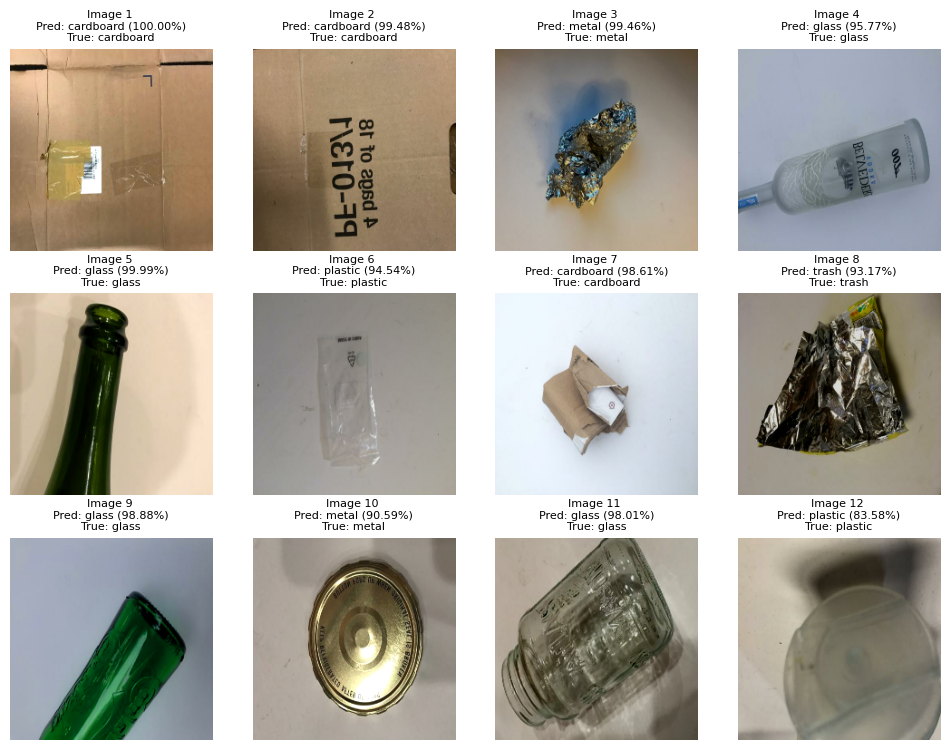

In [13]:
show_multiple_images_with_label_pred_tf_data(
  model=best_model,
  dataset=valid_tf_dataset_loaded,
  n_skip=1,
  num_images=12,
  figsize_per_image=(3, 3),
  classes_list=label_list
)

### plot prediction results from external data

In [14]:
class ImagePreprocessor:
    def __init__(self, target_size=(240, 240), channels=3):
        """Initialize the image preprocessor with the target size."""
        self.target_size = target_size
        self.channels = channels

    def _resize_image(self, image):
        """Resize input image to target size."""
        return tf.image.resize(image, self.target_size)

    def _normalize_image(self, image):
        """Normalize the image to the range [0, 1]."""
        image = tf.cast(image, tf.float32)
        image = image / 255.0
        return image

    def _augment_image(self, image):
        """Apply augmentation to the image (e.g. flipping, rotation)."""
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image

    def preprocess(self, image, augment=False):
        """
        Perform preprocessing on the image, including resizing, normalization, and optional augmentation.

        Args:
        image: Input image.
        augment: Flag to enable augmentation.

        Returns:
        Preprocessed image.
        """
        image = self._resize_image(image)
        if augment:
            image = self._augment_image(image)
        image = self._normalize_image(image)
        return image

    def prepare_for_model(self, image_input, augment=False, is_gray=False):
        """
        Prepare images for model input, either batch or single image.

        Args:
        image_input: Path to image or image Tensor.
        augment: Flag to enable augmentation.

        Returns:
        Preprocessed image ready for model.
        """
        if isinstance(image_input, str):
            channels = 1 if is_gray else 3
            image = tf.io.read_file(image_input)
            image = tf.image.decode_image(image, channels=channels)
        else:
            image = image_input

        image = self.preprocess(image, augment)

        image = tf.expand_dims(image, axis=0) if len(image.shape) == 3 else image
        return image

    def preprocess_batch(self, image_batch, augment=False):
        """
        Preprocessing for image batches, suitable for batch prediction or training.

        Args:
        image_batch: Batch of images in Tensor form.
        augment: Flag to enable augmentation.

        Returns:
        Batch of preprocessed images.
        """
        image_batch = tf.map_fn(lambda img: self.preprocess(img, augment), image_batch)
        return image_batch

In [15]:
def predict_image(model, processed_image, label_list, threshold=0.5):
    """
    Function to perform image prediction, supports binary and multiclass classification.

    Args:
    model: Trained model to perform prediction.
    processed_image: Preprocessed image for model input.
    label_list: List of labels for multiclass or binary classification.
    threshold: Threshold for binary classification (default = 0.5).

    Returns:
    Predicted label (string) from label_list.
    """
    predictions = model.predict(processed_image, verbose=0)
    predictions = tf.squeeze(predictions).numpy()

    if len(label_list) == 2:  
        predicted_label = label_list[int(predictions > threshold)]
    else:  
        predicted_label = label_list[np.argmax(predictions)]

    return predicted_label


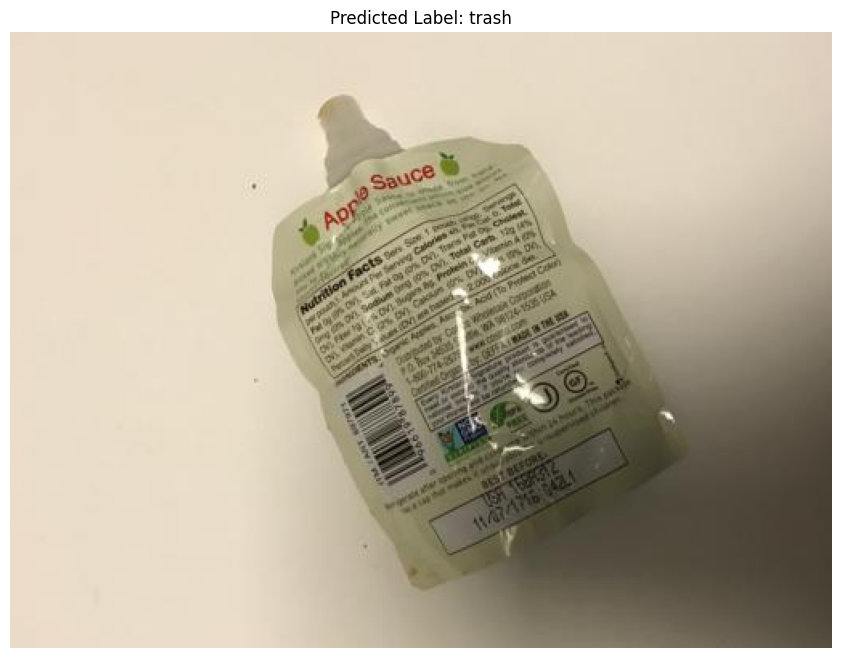

In [19]:
# Path gambar yang akan diproses
img_path = '../artifacts/data_ingestion/dataset-resized/trash/trash1.jpg'
image = Image.open(img_path)

preprocessor = ImagePreprocessor(target_size=(IMAGE_SIZE))
processed_image = preprocessor.prepare_for_model(img_path)
predicted_label = predict_image(best_model, processed_image, label_list)


plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')

plt.show()